In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
import xlens
import fitsio
from astropy.io import ascii as astascii

from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.integrate as integrate
import lsst.afw.image as afwImage
from scipy.spatial import KDTree

In [4]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/anacal_catalog_db2'
#obs_collection = 'test'
skymap = 'hsc'

tract_id = 10041
patch_id = 14
band = "i"

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
t_skymap = obs_butler.get('skyMap', skymap=skymap)

ref = list(obs_registry.queryDatasets(
    'sim_0_rot0_Coadd_anacal_force', skymap=skymap, 
    patch=patch_id, tract=tract_id, 
    band=band
))[0]

catalog = obs_butler.get(ref)

ref = list(obs_registry.queryDatasets(
    'sim_0_rot0_Coadd_anacal_joint', skymap=skymap, 
    patch=patch_id, tract=tract_id, 
))[0]
catalog_d = obs_butler.get(ref)

patch = t_skymap[tract_id][patch_id]
bbox = patch.getOuterBBox()
mag = 27 - np.log10(catalog[f"{band}_flux"]) * 2.5

In [8]:
bbox.getHeight() * bbox.getWidth()

17640000

In [5]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/dm_catalog'
skymap = 'hsc'
obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
ref = list(obs_registry.queryDatasets(
    'sim_0_rot0_Coadd_meas', skymap=skymap, 
    patch=patch_id, tract=tract_id, 
    band=band
))[0]
catalog_dm = obs_butler.get(ref)
msk2 = (
    (catalog_dm["deblend_nChild"] == 0) &
    (catalog_dm["modelfit_CModel_instFlux"] > 0.0) 
)
mag_dm = 27 - 2.5 * np.log10(catalog_dm["modelfit_CModel_instFlux"][msk2])
x_dm = np.array(catalog_dm["base_SdssCentroid_x"][msk2])
y_dm = np.array(catalog_dm["base_SdssCentroid_y"][msk2])

dm_coords = np.vstack((x_dm, y_dm)).T
dm_tree = KDTree(dm_coords)

In [9]:
cat_ref = fitsio.read(os.path.join(os.environ["CATSIM_DIR"], "OneDegSq.fits"))
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'
skymap = 'hsc'
obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
ref = list(obs_registry.queryDatasets(
    "sim_0_rot0_Coadd_truthCatalog", skymap=skymap, 
    patch=patch_id, tract=tract_id, 
    band=band
))[0]
catalog_truth = obs_butler.get(ref)

i_mag_truth = cat_ref[catalog_truth["index"]]["i_ab"]
mask = (i_mag_truth < 26.0)
catalog_truth=catalog_truth[mask]

x_truth = (bbox.beginX + catalog_truth["image_x"])
y_truth = (bbox.beginY + catalog_truth["image_y"])

g_mag_truth = cat_ref[catalog_truth["index"]]["g_ab"]
r_mag_truth = cat_ref[catalog_truth["index"]]["r_ab"]
i_mag_truth = cat_ref[catalog_truth["index"]]["i_ab"]
z_mag_truth = cat_ref[catalog_truth["index"]]["z_ab"]
y_mag_truth = cat_ref[catalog_truth["index"]]["y_ab"]

truth_coords = np.vstack((x_truth, y_truth)).T
truth_tree = KDTree(truth_coords)

Text(0, 0.5, 'number')

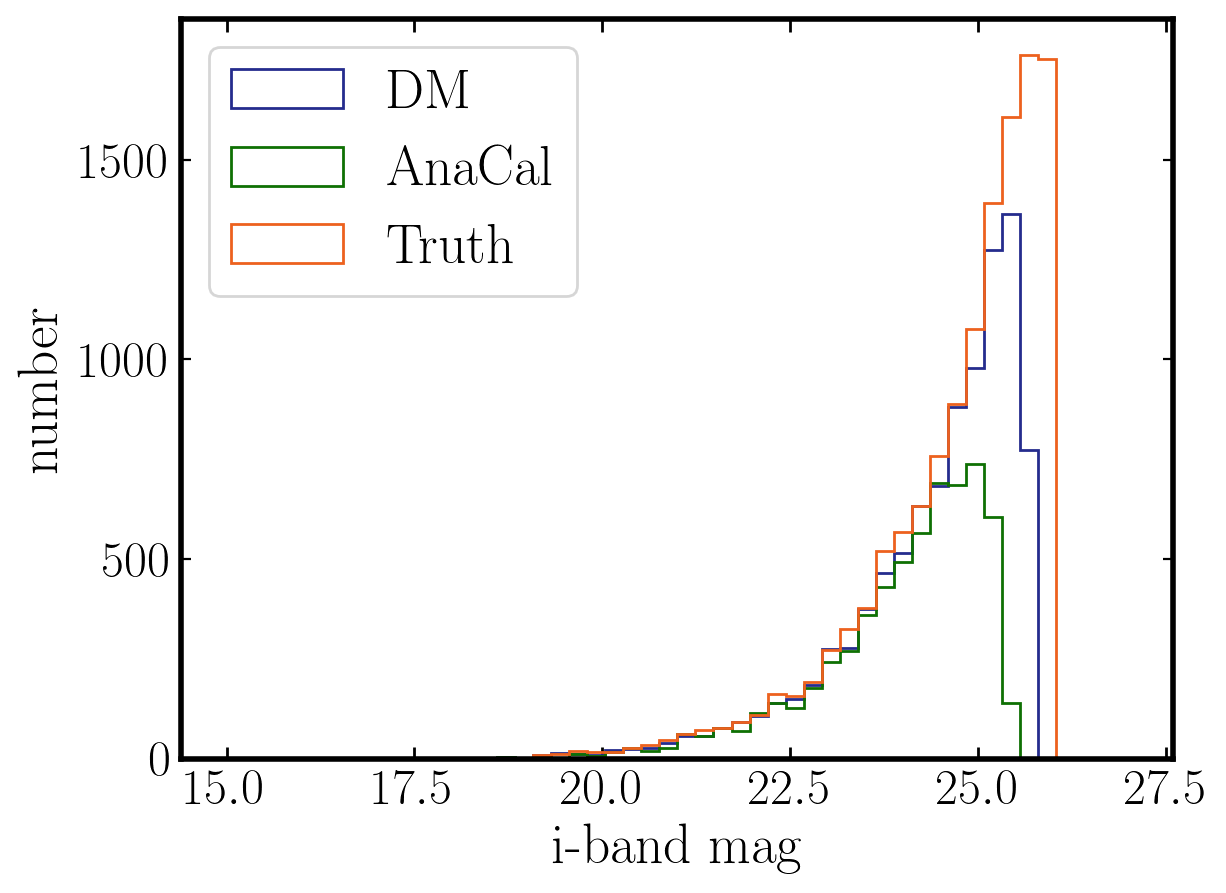

In [5]:
plt.hist(
    mag_dm,
    histtype="step", 
    density=False, 
    bins=50, range=(15, 27), 
    label="DM",
)

plt.hist(
    mag, 
    histtype="step", 
    density=False, 
    bins=50, range=(15, 27), 
    label="AnaCal",
)

plt.hist(
    i_mag_truth, 
    histtype="step", 
    density=False, 
    bins=50, range=(15, 27), 
    label="Truth",
)
plt.xlabel("magnitude")
plt.legend()
plt.xlabel("i-band mag")
plt.ylabel("number")

In [14]:
mag_list = [25, 24.8, 24.6, 24.4, 24.2, 24.0]
fraction = []
for mag_lim in mag_list:
    mask = ((27 - np.log10(catalog[f"{band}_flux"]) * 2.5) < mag_lim)
    cat = catalog[mask]
    catd = catalog_d[mask]
    mag2 = mag[mask]
    ndata = np.sum(mask)
    ana_coords = np.vstack(
        (catd['x1'] / 0.168, 
         catd['x2'] / 0.168)
    ).T
    ana_tree = KDTree(ana_coords)
    match_dist, match_ndx = ana_tree.query(truth_coords)
    mag_diffs = mag2[match_ndx] - i_mag_truth
    
    mask        = match_dist < 5
    dm_idx_full = np.arange(match_dist.size)[mask]        # indices in dm_tree
    ana_idx     = match_ndx[mask]                         # matching ANA indices
    abs_diffs   = np.abs(mag_diffs[mask])                 # |Δmag|
    
    order = np.lexsort((abs_diffs, ana_idx))
    dm_idx_sorted  = dm_idx_full[order]
    ana_idx_sorted = ana_idx[order]
    abs_diffs_sort = abs_diffs[order]
    
    _, first = np.unique(ana_idx_sorted, return_index=True)
    fraction.append(1.0 - len(first) / ndata)

Text(0.5, 0, 'i-band mag cut')

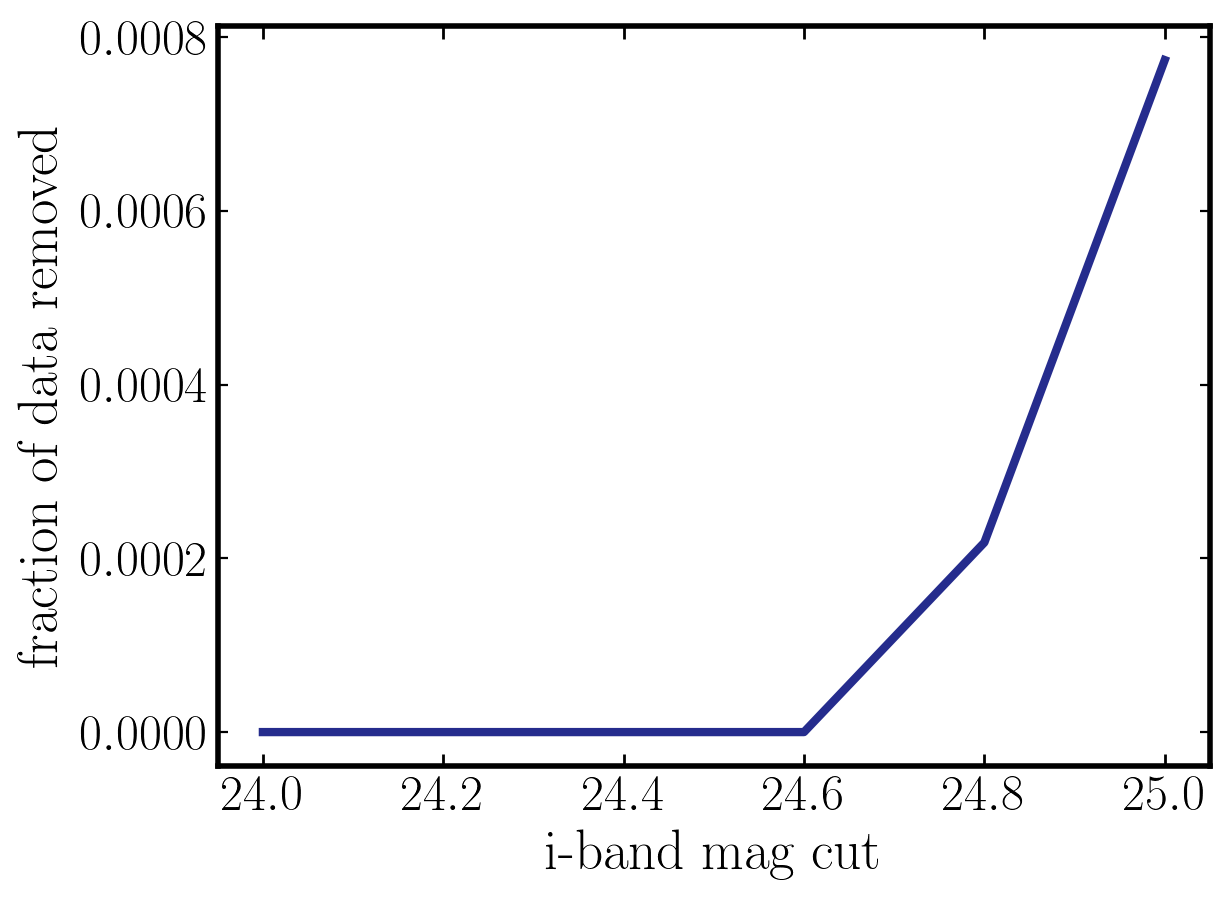

In [15]:
plt.plot(mag_list, fraction)
plt.ylabel("fraction of data removed")
plt.xlabel("i-band mag cut")

Text(0, 0.5, 'PDF')

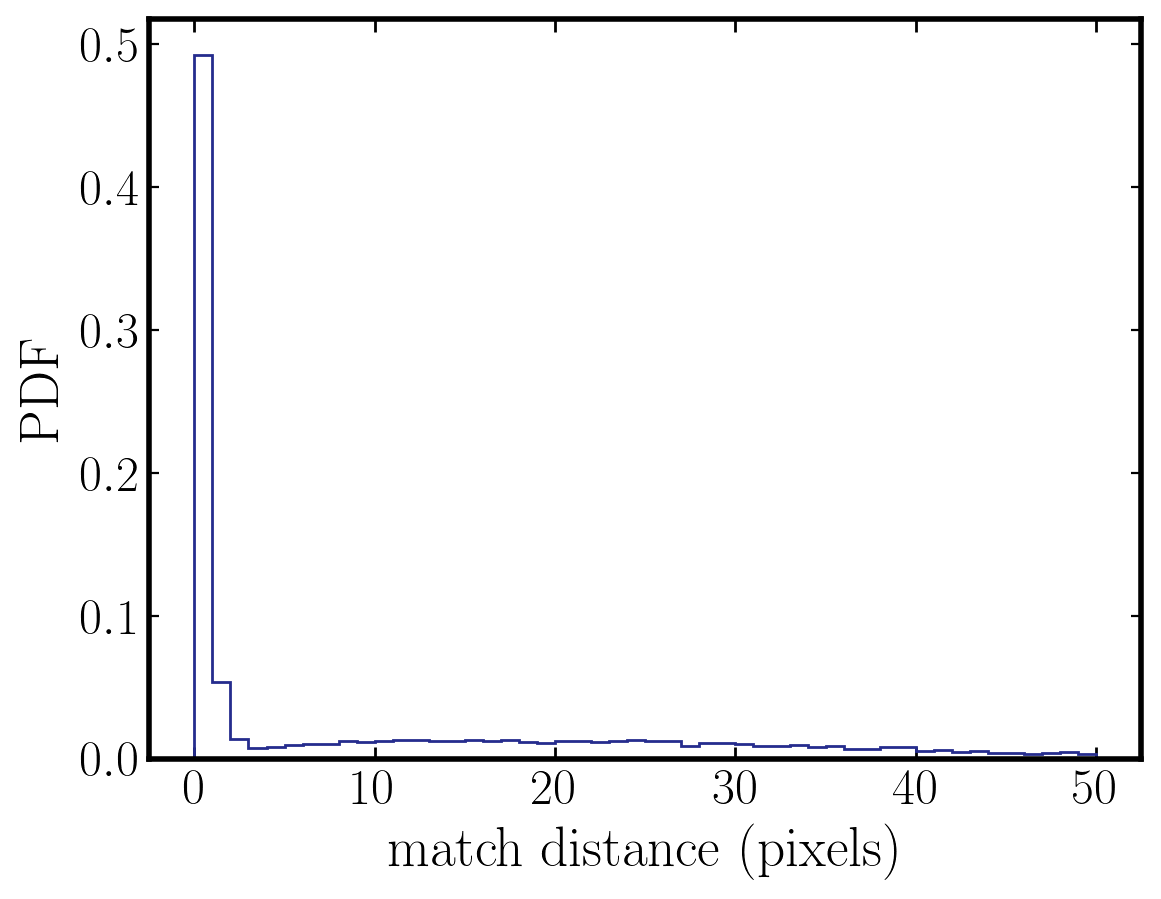

In [11]:
mag_lim = 25.5
mask = ((27 - np.log10(catalog[f"{band}_flux"]) * 2.5) < mag_lim)
cat = catalog[mask]
catd = catalog_d[mask]
mag2 = mag[mask]
ndata = np.sum(mask)
ana_coords = np.vstack(
    (catd['x1'] / 0.168, 
     catd['x2'] / 0.168)
).T
ana_tree = KDTree(ana_coords)


match_dist, match_ndx = ana_tree.query(truth_coords)
mag_diffs = mag2[match_ndx] - i_mag_truth

mask        = match_dist < 5
dm_idx_full = np.arange(match_dist.size)[mask]        # indices in dm_tree
ana_idx     = match_ndx[mask]                         # matching ANA indices
abs_diffs   = np.abs(mag_diffs[mask])                 # |Δmag|

order = np.lexsort((abs_diffs, ana_idx))
dm_idx_sorted  = dm_idx_full[order]
ana_idx_sorted = ana_idx[order]
abs_diffs_sort = abs_diffs[order]

_, first = np.unique(ana_idx_sorted, return_index=True)
fraction.append(1.0 - len(first) / ndata)

dm_keep   = dm_idx_sorted[first]      # unique DM indices to keep
ana_keep  = ana_idx_sorted[first]     # corresponding ANA indices
dmag_keep = mag_diffs[dm_keep]        # their signed Δmag values
plt.close()
plt.hist(match_dist, bins=50, histtype="step", range=(0, 50), density=True)
plt.xlabel("match distance (pixels)")
plt.ylabel("PDF")

Text(0, 0.5, 'PDF')

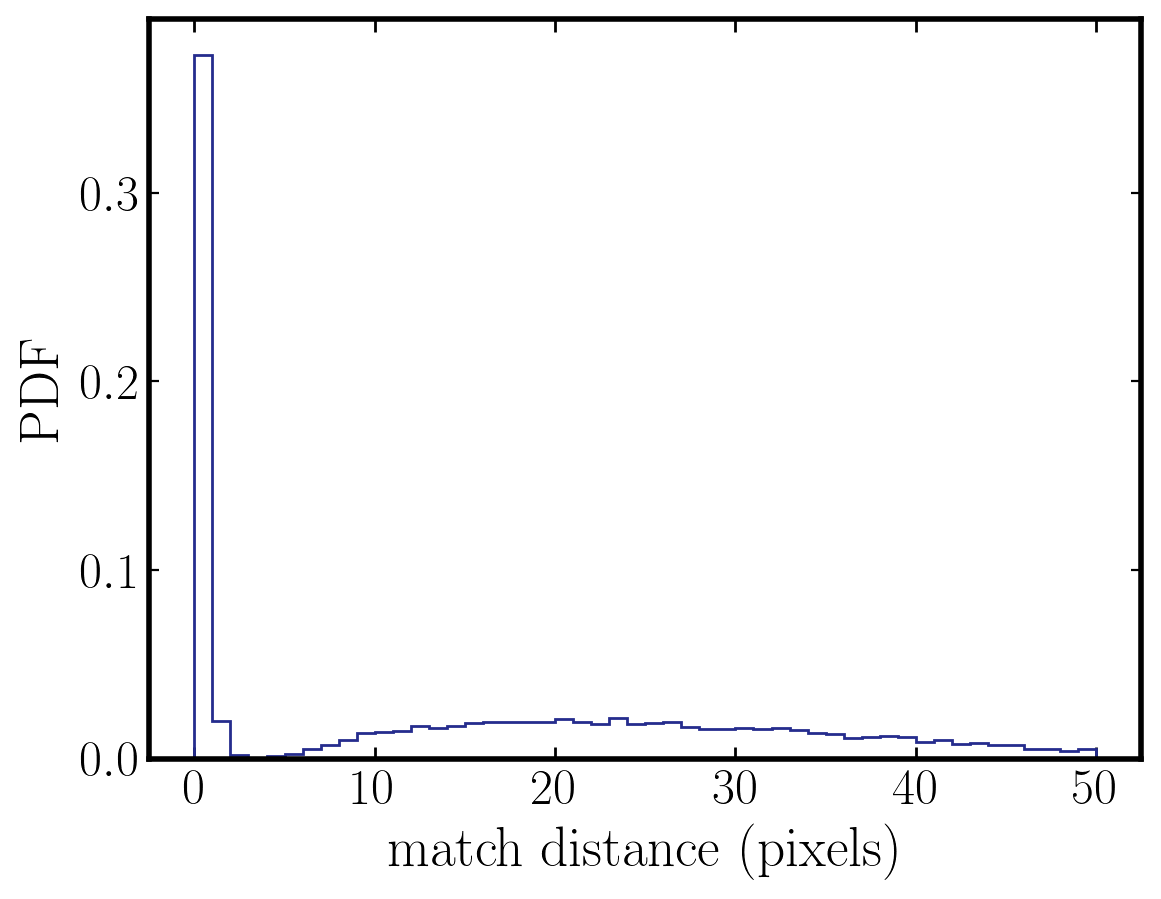

In [26]:
mag_lim = 25.5
mask = ((27 - np.log10(catalog[f"{band}_flux"]) * 2.5) < mag_lim)
cat = catalog[mask]
catd = catalog_d[mask]
mag2 = mag[mask]
ndata = np.sum(mask)
ana_coords = np.vstack(
    (catd['x1'] / 0.168, 
     catd['x2'] / 0.168)
).T
ana_tree = KDTree(ana_coords)


match_dist, match_ndx = ana_tree.query(dm_coords)
mag_diffs = mag2[match_ndx] - mag_dm

mask        = match_dist < 5
dm_idx_full = np.arange(match_dist.size)[mask]        # indices in dm_tree
ana_idx     = match_ndx[mask]                         # matching ANA indices
abs_diffs   = np.abs(mag_diffs[mask])                 # |Δmag|

order = np.lexsort((abs_diffs, ana_idx))
dm_idx_sorted  = dm_idx_full[order]
ana_idx_sorted = ana_idx[order]
abs_diffs_sort = abs_diffs[order]

_, first = np.unique(ana_idx_sorted, return_index=True)
fraction.append(1.0 - len(first) / ndata)

dm_keep   = dm_idx_sorted[first]      # unique DM indices to keep
ana_keep  = ana_idx_sorted[first]     # corresponding ANA indices
dmag_keep = mag_diffs[dm_keep]        # their signed Δmag values
plt.close()
plt.hist(match_dist, bins=50, histtype="step", range=(0, 50), density=True)
plt.xlabel("match distance (pixels)")
plt.ylabel("PDF")

0.02829493097532093


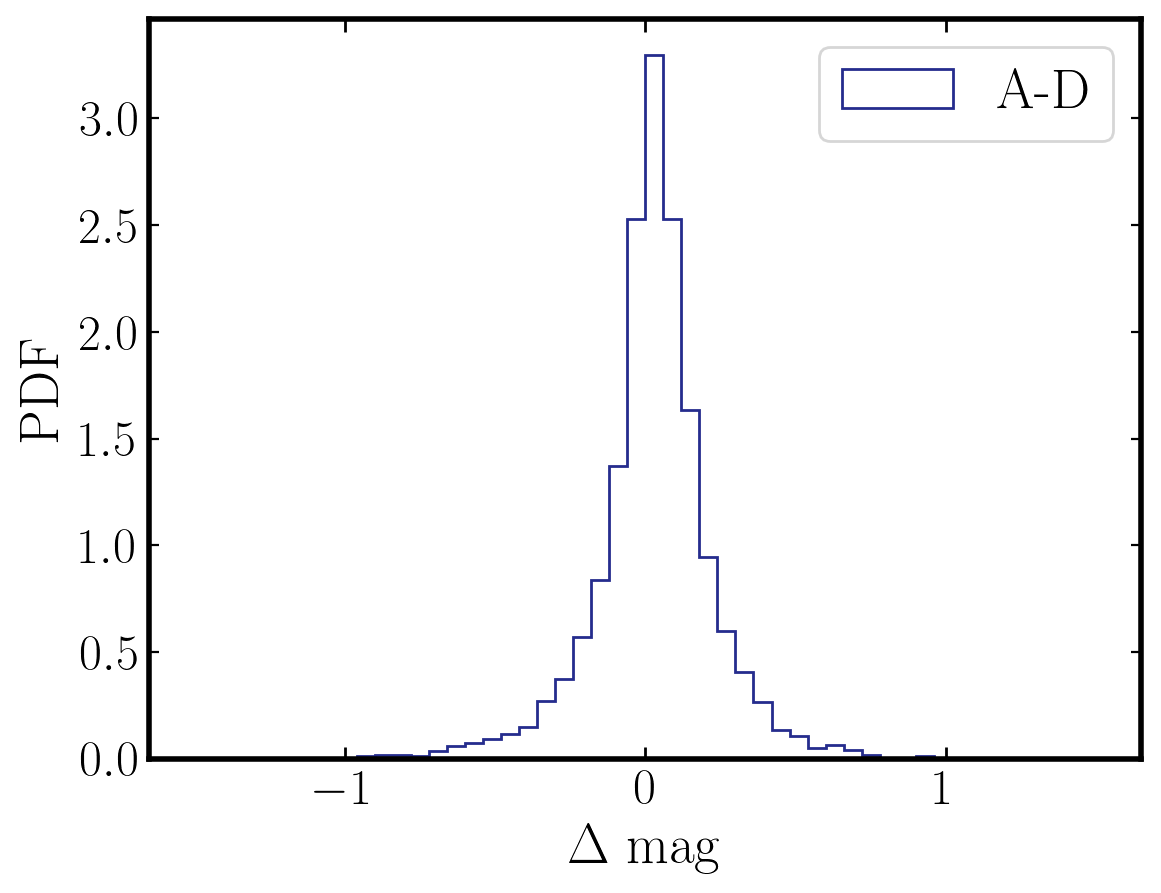

In [27]:
plt.close()
plt.hist(dmag_keep, range=(-1.5, 1.5), bins=50, density=True, histtype="step", label="A-D");
plt.xlabel(r"$\Delta$ mag")
plt.ylabel("PDF")
print(np.average(dmag_keep))
plt.legend()

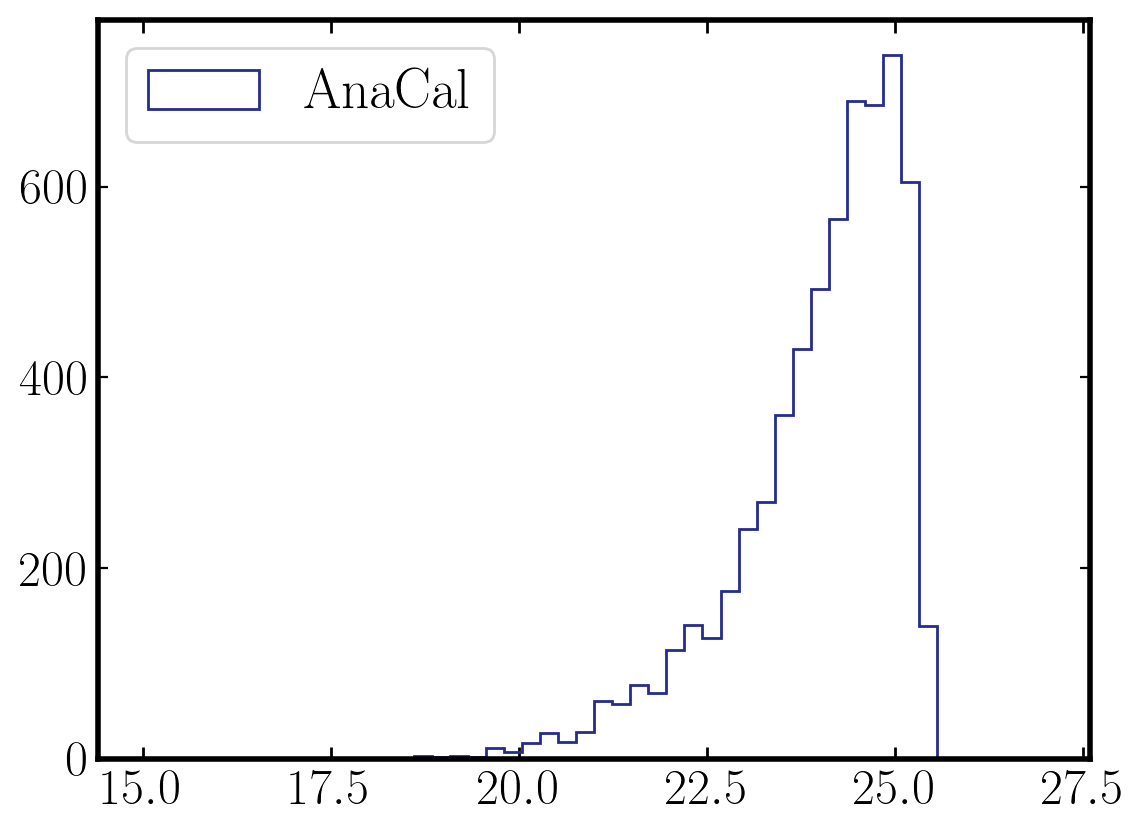

In [29]:
plt.hist(
    27 - np.log10(catalog["i_flux"]) * 2.5, 
    histtype="step", 
    density=False, 
    bins=50, range=(15, 27), 
    label="AnaCal"
)
plt.legend()